# EDA

In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import warnings
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)
def ignore_warn(*args, **kwargs):
	pass
warnings.warn = ignore_warn

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [5]:
print(train.shape)
print(test.shape)

(250, 302)
(19750, 301)


In [23]:
Y = train['target']
X = train.drop(['id','target'], axis = 1)
X_sub = test.drop('id', axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_sub = scaler.fit_transform(X_sub)

## Basic Inspection

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [50]:
VIF = add_constant(features)
pd.Series([variance_inflation_factor(VIF.values, i) 
               for i in range(VIF.shape[1])], 
              index=VIF.columns)

const    1.013446
0        1.015120
1        1.015636
2        1.016781
3        1.015584
4        1.013578
5        1.013577
6        1.014286
7        1.016677
8        1.012806
9        1.014183
10       1.013970
11       1.016152
12       1.015354
13       1.013777
14       1.016781
15       1.013783
16       1.015674
17       1.015678
18       1.013681
19       1.015875
20       1.014030
21       1.015337
22       1.017739
23       1.015827
24       1.016449
25       1.014719
26       1.014584
27       1.015164
28       1.017416
29       1.014305
30       1.017292
31       1.016113
32       1.014073
33       1.014632
34       1.015954
35       1.016197
36       1.014946
37       1.014076
38       1.016127
39       1.016164
40       1.016723
41       1.015025
42       1.014381
43       1.014900
44       1.015357
45       1.016378
46       1.014260
47       1.016083
48       1.015471
49       1.014915
50       1.016322
51       1.015007
52       1.013460
53       1.014029
54       1

### Logistic

In [10]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [11]:
ros = RandomOverSampler(random_state = 0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
X_train_rsed, Y_train_rsed = ros.fit_resample(X_train, Y_train)

In [12]:
print(np.mean(Y_train))
print(np.mean(Y_test))

0.645
0.62


In [54]:
lr = LogisticRegression()
C = np.linspace(1,100,5)
params = {"C": C}
lr_cv = GridSearchCV(lr, params, cv = 5, n_jobs = -1)
lr_cv.fit(X_train_rsed, Y_train_rsed)
print(C)
print(lr_cv.best_params_)
print(lr_cv.cv_results_['mean_test_score'])

[  1.    25.75  50.5   75.25 100.  ]
{'C': 75.25}
[0.80232558 0.80620155 0.80620155 0.81007752 0.81007752]


0.8081494057724957


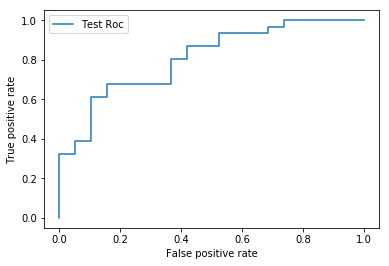

In [56]:
from sklearn.metrics import roc_auc_score, roc_curve
lr = lr_cv.best_estimator_
lr.fit(X_train_rsed, Y_train_rsed)
lr_pre = lr.predict_proba(X_test)[:,1]
print(roc_auc_score(Y_test, lr_pre))
fpr, tpr, thresholds = roc_curve(Y_test, lr_pre)
plt.plot(fpr, tpr, label="Test Roc")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()

In [29]:
lr = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1,solver="liblinear")
lr.fit(X,Y)
submission['target'] = lr.predict_proba(X_sub)[:,1]
submission.to_csv("log.csv",index = False)

### Gradient Boosting

In [82]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
l_r = [0.02,0.05,0.1]
m_d = [4,5,6]
n_e = [90,95,100]
params = {"max_depth": m_d, "n_estimators": n_e, "learning_rate": l_r}
gbm_cv = GridSearchCV(gbm, params, cv = 5, n_jobs = -1)
gbm_cv.fit(X_train_rsed, Y_train_rsed)
print(gbm_cv.best_params_)
print(gbm_cv.cv_results_['mean_test_score'])

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 95}
[0.77131783 0.77906977 0.79069767 0.76744186 0.76356589 0.77131783
 0.74418605 0.75193798 0.74031008 0.79844961 0.79844961 0.80620155
 0.7751938  0.78682171 0.7751938  0.73255814 0.75193798 0.75193798
 0.80620155 0.81395349 0.81007752 0.77906977 0.76744186 0.75193798
 0.75581395 0.75581395 0.75968992]


0.8047538200339559


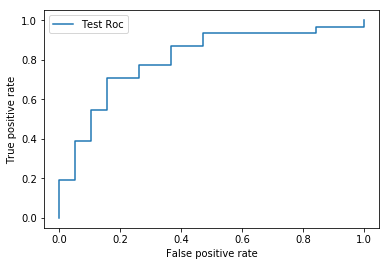

In [83]:
gbm = gbm_cv.best_estimator_
gbm.fit(X_train_rsed, Y_train_rsed)
gbm_pre = gbm.predict_proba(X_test)[:,1]
print(roc_auc_score(Y_test, gbm_pre))
fpr, tpr, thresholds = roc_curve(Y_test, gbm_pre)
plt.plot(fpr, tpr, label="Test Roc")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()

In [84]:
gbm.fit(X_rsed,Y_rsed)
submission['target'] = gbm.predict(X_sub)
submission.to_csv("gbm.csv", index = False)

### XGBoost

In [31]:
from xgboost import XGBClassifier
xgb = XGBClassifier(silent = 1, eta = 0.05)
c_b = [0.4, 0.5, 0.6]
m_d = [5,6,7]
n_e = [100,200,300]
params = {"max_depth": m_d, "n_estimators": n_e, "colsample_bytree": c_b}
xgb_cv = GridSearchCV(xgb, params, cv = 5, n_jobs = -1)
xgb_cv.fit(X_train_rsed, Y_train_rsed)
print(xgb_cv.best_params_)
print(xgb_cv.cv_results_['mean_test_score'])

{'colsample_bytree': 0.4, 'max_depth': 5, 'n_estimators': 200}
[0.85658915 0.87209302 0.87209302 0.86046512 0.85271318 0.85271318
 0.86046512 0.85271318 0.86046512 0.8255814  0.8372093  0.8372093
 0.83333333 0.8372093  0.86046512 0.82170543 0.8372093  0.84883721
 0.81395349 0.8255814  0.82945736 0.8255814  0.82945736 0.84108527
 0.83333333 0.83333333 0.82945736]


0.8047538200339559


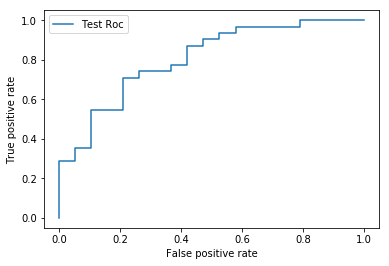

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
X_test1 = X_test.as_matrix()
xgb = xgb_cv.best_estimator_
xgb.fit(X_train_rsed, Y_train_rsed)
xgb_pre = xgb.predict_proba(X_test1)[:,1]
print(roc_auc_score(Y_test, xgb_pre))
fpr, tpr, thresholds = roc_curve(Y_test, xgb_pre)
plt.plot(fpr, tpr, label="Test Roc")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()

In [33]:
xgb.fit(X,Y)
submission['target'] = xgb.predict_proba(X_sub)[:,1]
submission.to_csv("xgb.csv", index = False)